<div class="one">
  <h1>Classification</h1>
</div>
<style>
  div{
    background-color: SkyBlue;
  }
  h1 {
  position: relative;
  padding: 0;
  margin: 0;
  font-family: "Raleway", sans-serif;
  font-weight: 300;
  font-size: 40px;
  color: #080808;
  -webkit-transition: all 0.4s ease 0s;
  -o-transition: all 0.4s ease 0s;
  transition: all 0.4s ease 0s;
}
h1 span {
  display: block;
  font-size: 0.5em;
  line-height: 1.3;
}
h1 em {
  font-style: normal;
  font-weight: 600;
}
/* === HEADING STYLE #1 === */
.one h1 {
  text-align: center;
  text-transform: uppercase;
  padding-bottom: 5px;
}
.one h1:before {
  width: 28px;
  height: 5px;
  display: block;
  content: "";
  position: absolute;
  bottom: 3px;
  left: 50%;
  margin-left: -14px;
  background-color: #b80000;
}
.one h1:after {
  width: 100px;
  height: 1px;
  display: block;
  content: "";
  position: relative;
  margin-top: 25px;
  left: 50%;
  margin-left: -50px;
  background-color: #b80000;
}
</style>

## XGBoost
eXtreme Gradient Boosting의 약자로, **Boosting기법**을 이용하여 구현한 알고리즘.

대표적인 알고리즘으로는 Gradient Boosting이 있으며, 해당 알고리즘을 병렬 학습이 되게끔 구현한 것이 XGBoost이다.

Regression, Classification 문제를 모두 지원하며, 성능과 자원 효율이 좋아서 인기가 좋다.

### Boosting?
여러개의 성능이 높지 않은 모델을 조합해서 사용하는 ensemble 기법 중 하나. 아래와 같은 장점들이 존재한다.
- 기존 Boosting 모델 대비 빠른 수행시간(병렬 처리)
- 과적합 규제 지원(Regularization)
- 분류와 회귀 task에서 높은 예측 성능
- Early Stopping 기능 제공
- 다양한 옵션을 제공하기에 Customizing 용이함
- 결측치 내부 처리

이전 모델의 오류를 순차적으로 보완해나가는 방식으로 모델을 형성하는데, 아래 수식을 참고해보자

> model1 $\rarr$ $Y = w1 * H(x) + error1$ <br>
> supplementation $error1$ $\rarr$ $error1 = w2*G(x) + error2$ <br>
> model2 $\rarr$ $Y = w1 * H(x) + w2*G(x) + error2$ <br>
> supplementation $error2$ $\rarr$ $error2 = w3*M(x) + error3$ <br>
> model3 $\rarr$ $Y = w1 * H(x) + w2*G(x) + w3*M(x) + error3$ <br>
> supplementation $error3$ $\rarr$ $error3 = w4*K(x) + error4$ <br>
> ...

### Transcription

> https://www.kaggle.com/code/lucamassaron/steel-plate-eda-xgboost-is-all-you-need#Introduction-to-EDA/Modelling-for-Multi-Class-Prediction-of-Steel-Plate-Defect-Prediction

위 노트북에서는 playgrond 대회 주제였던 **철판 결함 종류 분류**를 진행했다.

### Load Data and first exploration

In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv("../data/train.csv").set_index("id")
test = pd.read_csv("../data/test.csv").set_index("id")

In [3]:
train.columns  # 학습용 데이터셋 컬럼

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

In [4]:
train.head().T

id,0,1,2,3,4
X_Minimum,584.0000,808.0000,3.900000e+01,7.810000e+02,1540.0000
X_Maximum,590.0000,816.0000,1.920000e+02,7.890000e+02,1560.0000
Y_Minimum,909972.0000,728350.0000,2.212076e+06,3.353146e+06,618457.0000
Y_Maximum,909977.0000,728372.0000,2.212144e+06,3.353173e+06,618502.0000
Pixels_Areas,16.0000,433.0000,1.138800e+04,2.100000e+02,521.0000
X_Perimeter,8.0000,20.0000,7.050000e+02,1.600000e+01,72.0000
Y_Perimeter,5.0000,54.0000,4.200000e+02,2.900000e+01,67.0000
Sum_of_Luminosity,2274.0000,44478.0000,1.311391e+06,3.202000e+03,48231.0000
Minimum_of_Luminosity,113.0000,70.0000,2.900000e+01,1.140000e+02,82.0000
Maximum_of_Luminosity,140.0000,111.0000,1.410000e+02,1.340000e+02,111.0000


위 데이터셋은 7가지 유형의 표면 손상이 존재한다.
- Pastry
- Z_Scratch 
- K_Scatch
- Stains
- Dirtness
- Bumps
- Other Faults

EDA를 시작하기 전, target column을 분할해보자.

In [5]:
target_classes = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target_bin = train[target_classes]
train = train.drop(target_classes, axis='columns')

### Target Analysis

분류 대상이 되는 데이터를 우선적으로 분석한다.

In [6]:
target_bin.sum(axis=0)

Pastry          1466
Z_Scratch       1150
K_Scatch        3432
Stains           568
Dirtiness        485
Bumps           4763
Other_Faults    6558
dtype: int64

우선 각 결함 유형들을 살펴보자면,

- Pastry : 운송 중 제조 공정이나 취급의 불완전성으로 인해 강판 표면에 작은 패치나 불규칙성이 생기는 것을 의미함. 이러한 불완전성은 강판 표면의 매끄러움과 외관에 영향을 줌
- Z_Scratch : 압연 방향와 평행하게 진행되는 강판 표면의 좁은 스크래치 또는 자국. 생산 또는 운송 중 취급, 가공 또는 연마제 접촉과 같은 요인에 의해 발생 가능
- K_Scatch : Z 스크래치와 비슷하지만 롤링 방향에 수직으로 생기는 스크래치. 제조 또는 운송 과정 중 취급, 가공 또는 연마제 접촉과 같은 요인에 의해 발생 가능
- Stains : 강판 표면의 변색되거나 오염된 부분. 가공, 보관 또는 취급 중에 녹, 기름, 기타 이물질의 접촉으로 인해 발생 가능
- Dirtness : 강판 표면에 먼지나 미립자 물질이 있음을 의미. 제조, 취급 또는 보관 과정에서 축적되는 다야한 유형의 이물질 또는 오염 물질 포함 가능
- Bumps : 강판 표면의 돌출된 부분. 이는 고르지 않은 롤링이나 냉각과 같은 제조 공정의 불규칙성, 취급 또는 운송 중 물리적 손상으로 인해 발생 가능
- Other Faults : 위에서 설명한 유형 외에 광범위한 부분에서의 결함.

In [7]:
target_bin.sum(axis=1).value_counts()

1    18380
0      818
2       21
Name: count, dtype: int64

800개가 넘는 데이터의 경우 결함이 없고, 21개의 데이터에는 2가지의 결함이 있다.

In [8]:
target_bin[target_bin.sum(axis=1) == 2]

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
634,0,0,1,0,0,0,1
752,0,0,1,0,0,0,1
3572,0,0,1,0,0,1,0
4416,0,0,1,0,0,0,1
4530,0,0,1,0,0,0,1
4664,0,0,1,0,0,0,1
6448,0,0,1,0,0,0,1
7589,0,0,1,0,0,0,1
8075,0,0,1,0,0,0,1


현재 다중 결함이 있는 값들의 경우 K_Scratch를 포함한 다중 결함이며, 이외 다른 결함들이 함께 포함되어 있는 형태이기에, 해당 값들은 K_Scratch로 분류한다.

In [9]:
target_classes = ['Zero_Defects', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

0~7, 총 8개의 라벨로 라벨링한다.

In [10]:
target = target_bin@(np.arange(target_bin.shape[1]) + 1)  # @ : 행렬 곱셈 연산자
target[target_bin.sum(axis=1) == 2] = 3

In [11]:
target.value_counts() / len(target)

7    0.340288
6    0.247724
3    0.178573
1    0.076227
2    0.059837
0    0.042562
4    0.029554
5    0.025235
Name: count, dtype: float64

### 클래스 간 분포 시각화

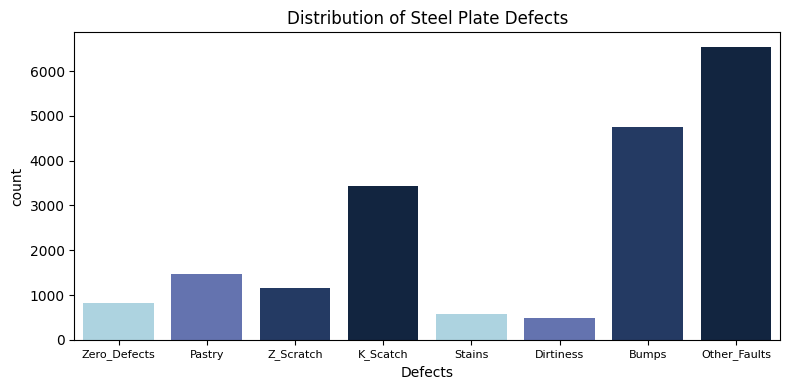

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

color_list = ['#A5D7E8', '#576CBC', '#19376D', '#0B2447']
cmap_custom = ListedColormap(color_list)

plt.figure(figsize=(8, 4))
ax = sns.countplot(x=target, palette=color_list)
ax.set_xticklabels(target_classes)

plt.title("Distribution of Steel Plate Defects")
plt.xlabel('Defects')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center", fontsize=8)
plt.tight_layout()
plt.show()

### EDA 

target column들을 제외한 기타 데이터들의 경우 각 결함을 자세히 설명하는 27개의 컬럼들이 존재한다. 자세한 내용은 아래와 같다.

1. 위치 특징:
    - X_Minimum : 결함 위치 x 최소 좌표
    - X_Maximum : 결함 위치 x 최대 좌표
    - Y_Minimum : 결함 위치 y 최소 좌표
    - Y_Maximum : 결함 위치 y 최대 좌표

2. 크기 특징:
    - Pixels_Areas : 픽셀 단위 결함 영역
    - X_Perimeter : 단층의 x축 둘레
    - Y_Perimeter : 단층의 y축 둘레

3. 광도 특징:
    - Sum_of_Luminosity : 결함 영역의 광도 값의 합
    - Minimum_of_Luminosity : 결함 영역의 최소 광도값
    - Maximum_of_Luminosity : 결함 영역의 최대 광도값

4. 재료 및 인덱스 특징:
    - TypeOfSteel_A300 : 강철 종류(A300)
    - TypeOfSteel_A400 : 강철 종류(A400)
    - Steel_Plate_Thickness : 철판 두께
    - Edges_Index, Empty_Index, Square_Index, Outside_X_Index, Edges_X_Index, Edges_Y_Index, Outside_Global_Index : 엣지 및 기하학 관련 인덱스값

5. 로그 특징:
    - LogOfAreas : 결함 영역의 로그값
    - Log_X_Index, Log_Y_Index : X및 Y좌표와 관련된 로그 인덱스

6. 통계 특징:
    - Orientation_Index : 방향을 설명하는 인덱스
    - Luminosity_Index : 광도와 관련된 지수
    - SigmoidOfAreas : 시그모이드 함수를 결함 영역에 적용한 결과

### 결측값 확인

In [13]:
train.isnull().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
dtype: int64

In [15]:
train.dtypes

X_Minimum                  int64
X_Maximum                  int64
Y_Minimum                  int64
Y_Maximum                  int64
Pixels_Areas               int64
X_Perimeter                int64
Y_Perimeter                int64
Sum_of_Luminosity          int64
Minimum_of_Luminosity      int64
Maximum_of_Luminosity      int64
Length_of_Conveyer         int64
TypeOfSteel_A300           int64
TypeOfSteel_A400           int64
Steel_Plate_Thickness      int64
Edges_Index              float64
Empty_Index              float64
Square_Index             float64
Outside_X_Index          float64
Edges_X_Index            float64
Edges_Y_Index            float64
Outside_Global_Index     float64
LogOfAreas               float64
Log_X_Index              float64
Log_Y_Index              float64
Orientation_Index        float64
Luminosity_Index         float64
SigmoidOfAreas           float64
dtype: object

In [16]:
train.nunique()

X_Minimum                1191
X_Maximum                1259
Y_Minimum                3345
Y_Maximum                3341
Pixels_Areas             1154
X_Perimeter               460
Y_Perimeter               331
Sum_of_Luminosity        2595
Minimum_of_Luminosity     162
Maximum_of_Luminosity      98
Length_of_Conveyer         99
TypeOfSteel_A300            2
TypeOfSteel_A400            2
Steel_Plate_Thickness      27
Edges_Index              1849
Empty_Index              1748
Square_Index             1118
Outside_X_Index           525
Edges_X_Index            1102
Edges_Y_Index             900
Outside_Global_Index        4
LogOfAreas               1072
Log_X_Index               206
Log_Y_Index               241
Orientation_Index        1598
Luminosity_Index         2046
SigmoidOfAreas            467
dtype: int64

In [17]:
train['TypeOfSteel_A300'].value_counts()

TypeOfSteel_A300
0    11480
1     7739
Name: count, dtype: int64

In [18]:
train['TypeOfSteel_A400'].value_counts()

TypeOfSteel_A400
1    11461
0     7758
Name: count, dtype: int64

In [19]:
train['Steel_Plate_Thickness'].value_counts()

Steel_Plate_Thickness
40     7625
70     3703
80     1661
100    1433
50     1011
60      856
200     748
300     434
175     396
69      283
90      211
150     191
120     164
143     138
185     116
220     105
130      44
125      24
85       21
211      18
290      11
250       8
140       8
180       7
159       1
81        1
86        1
Name: count, dtype: int64

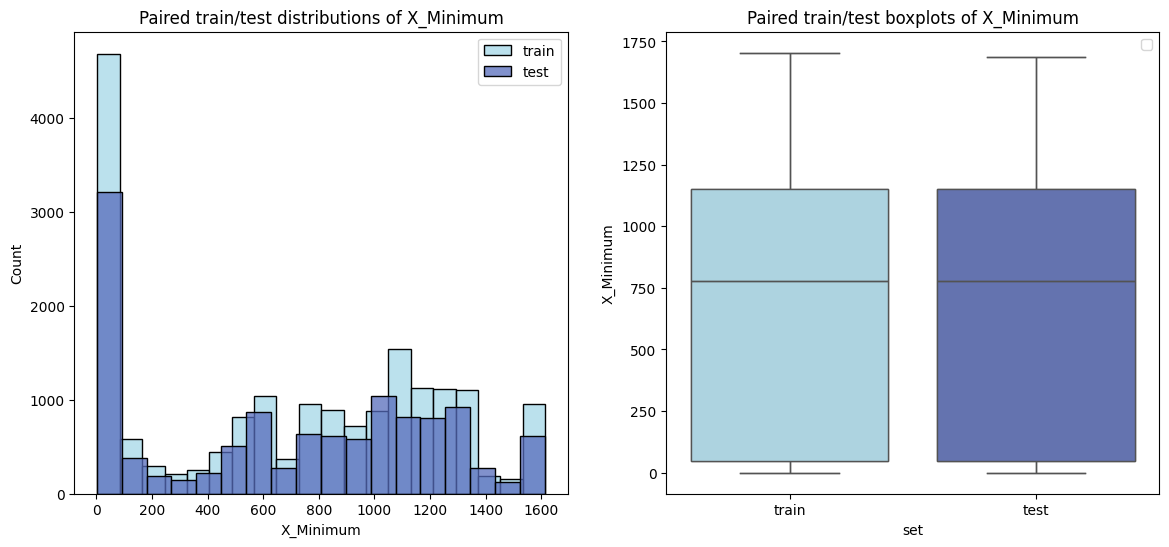

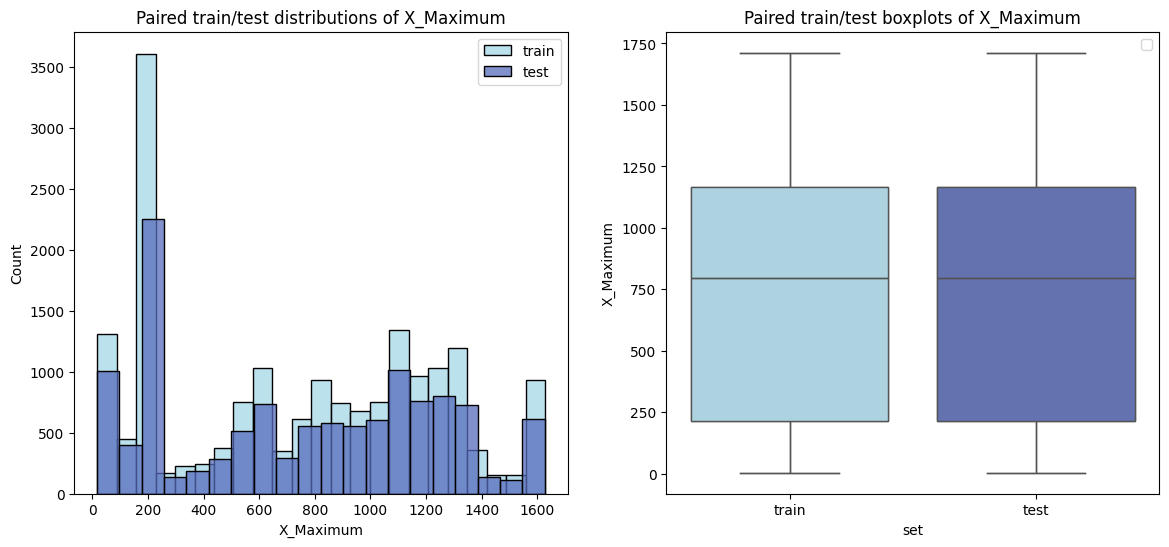

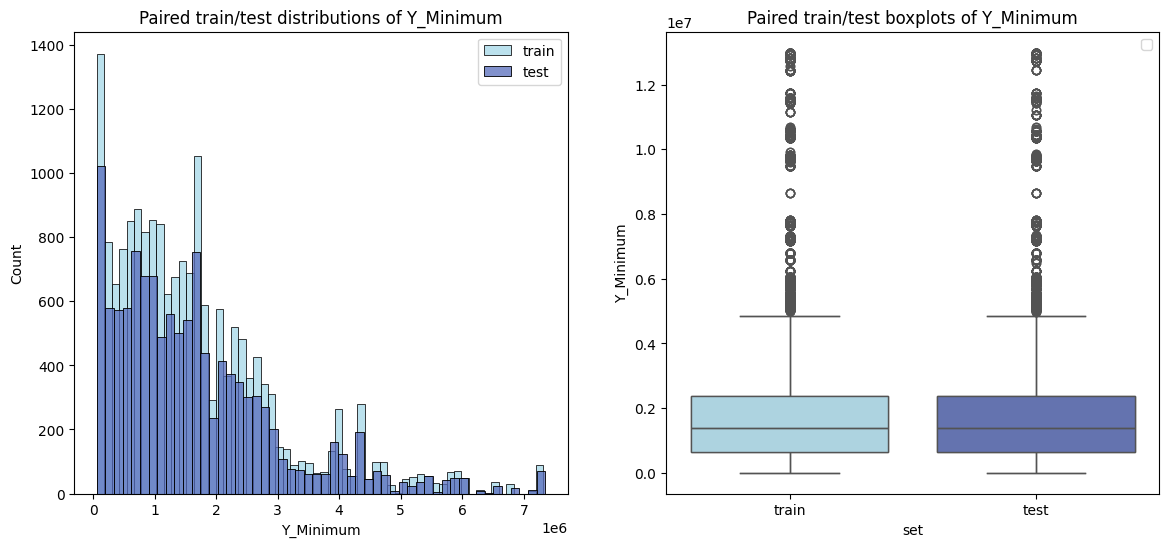

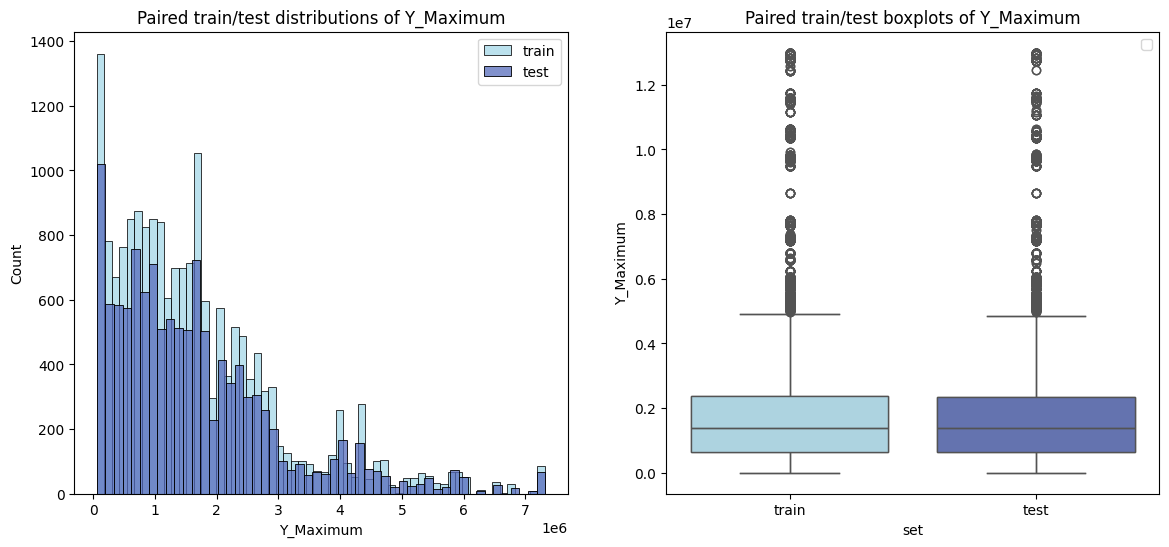

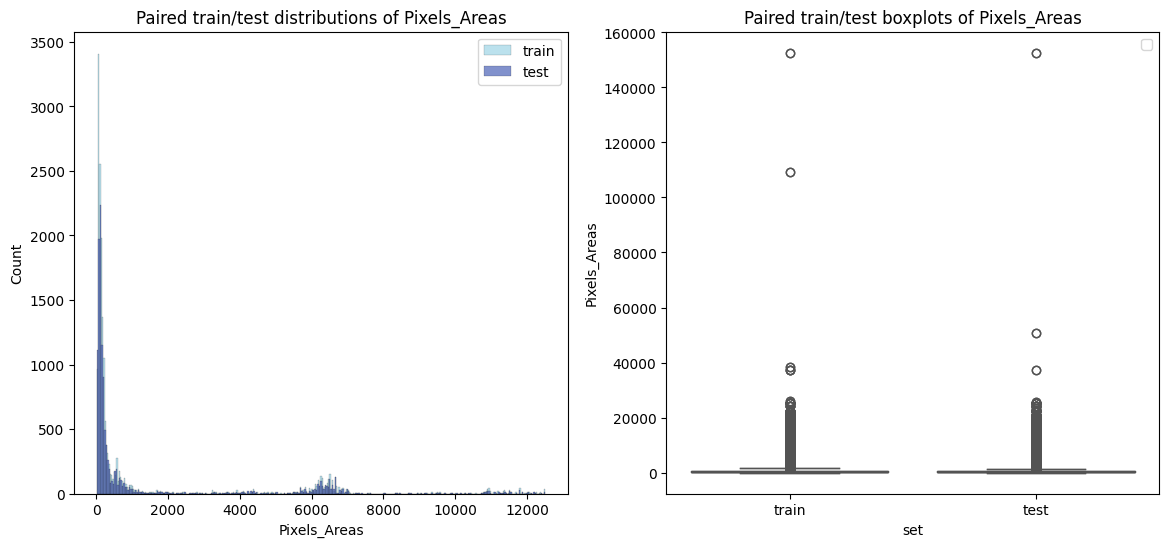

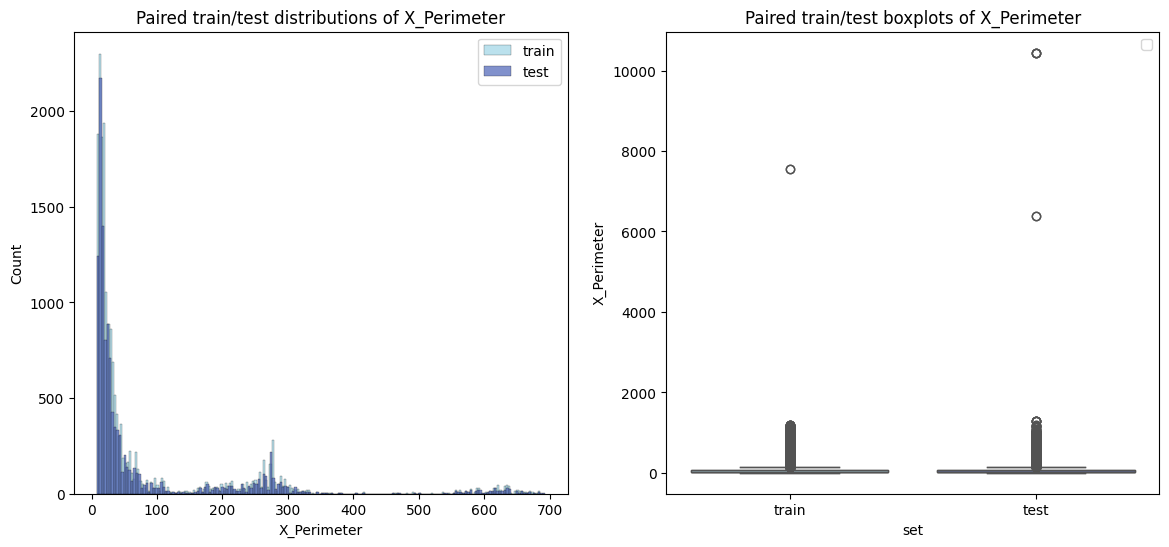

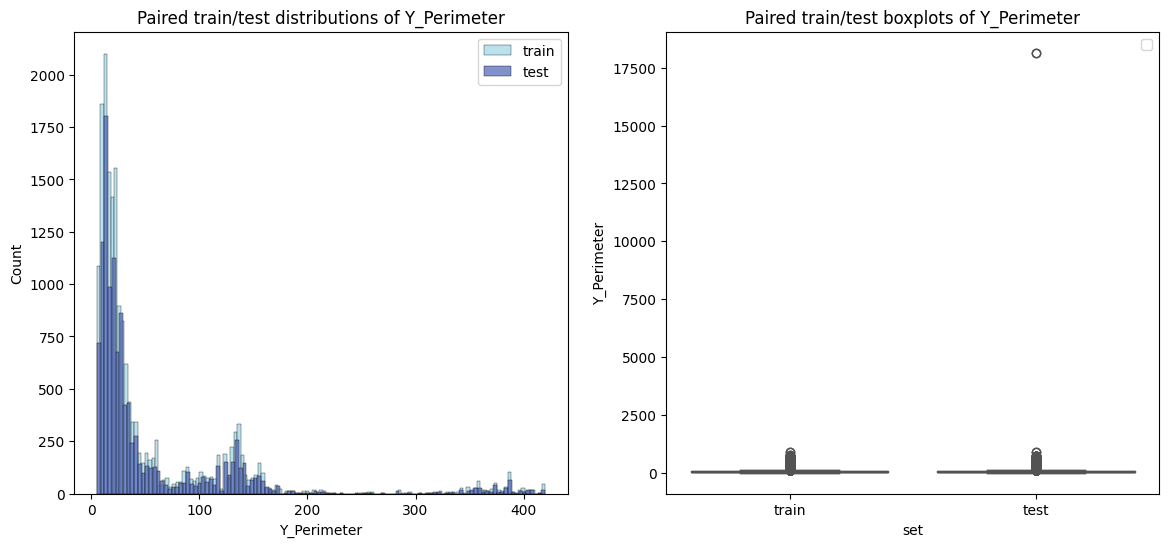

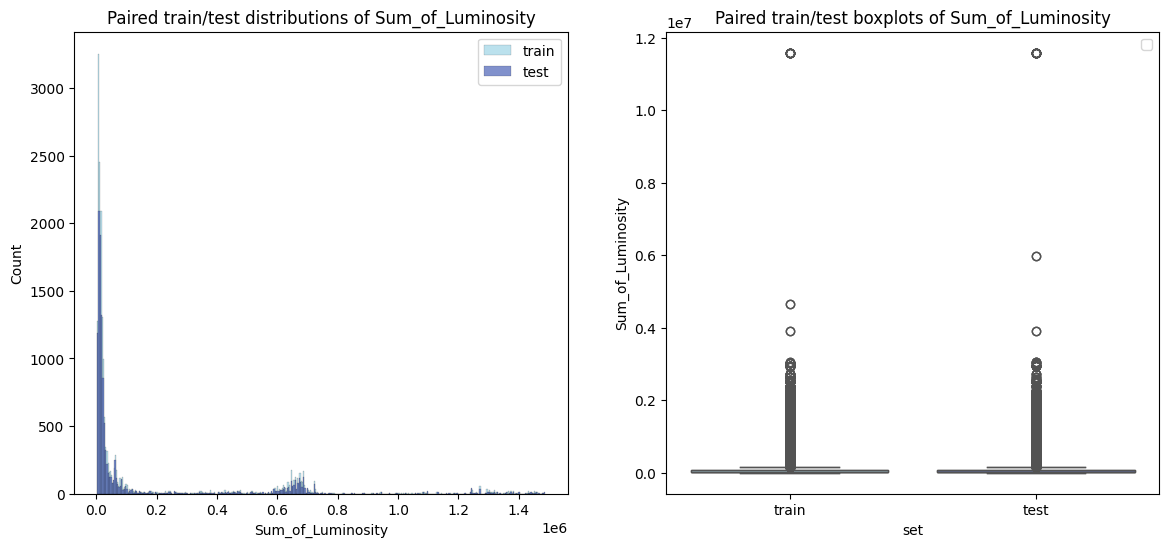

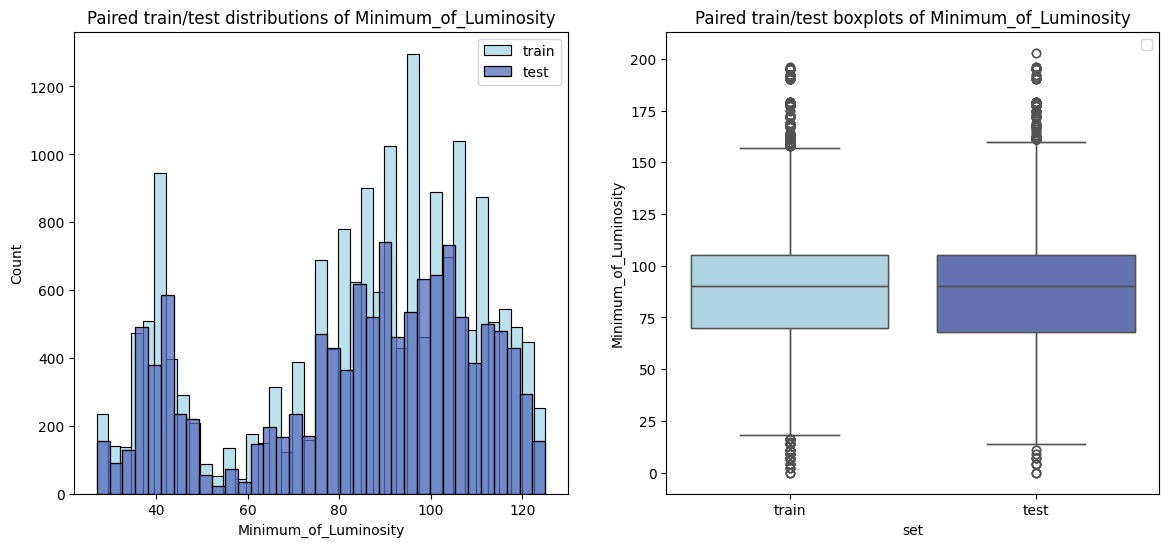

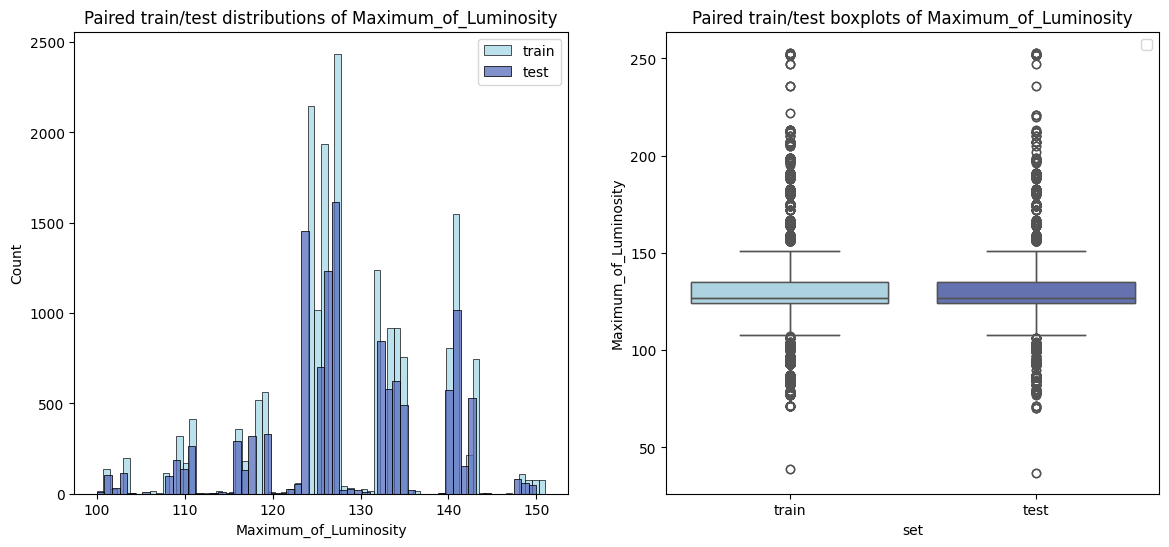

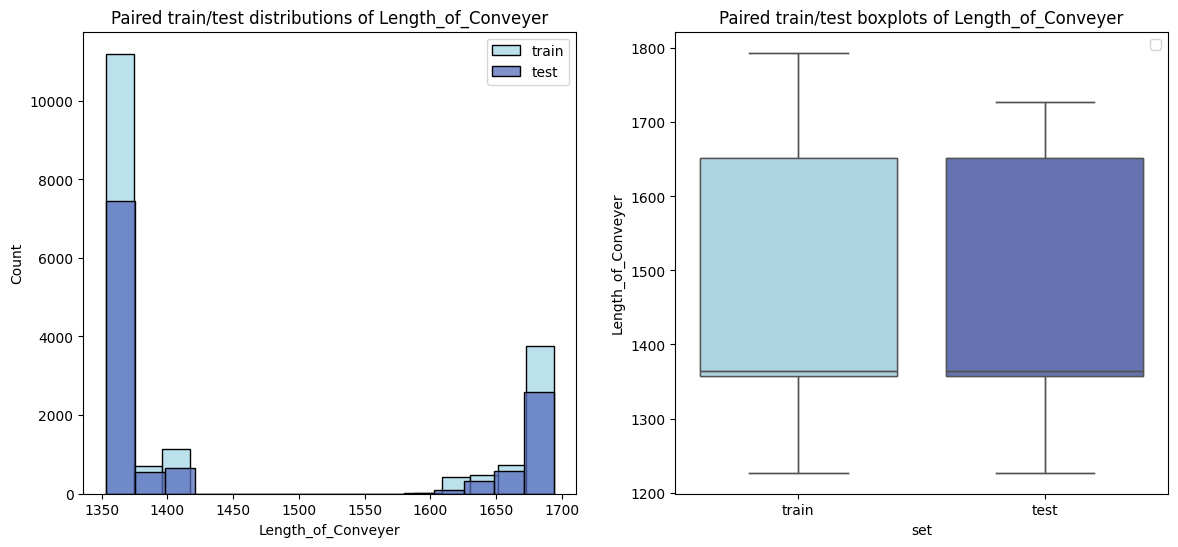

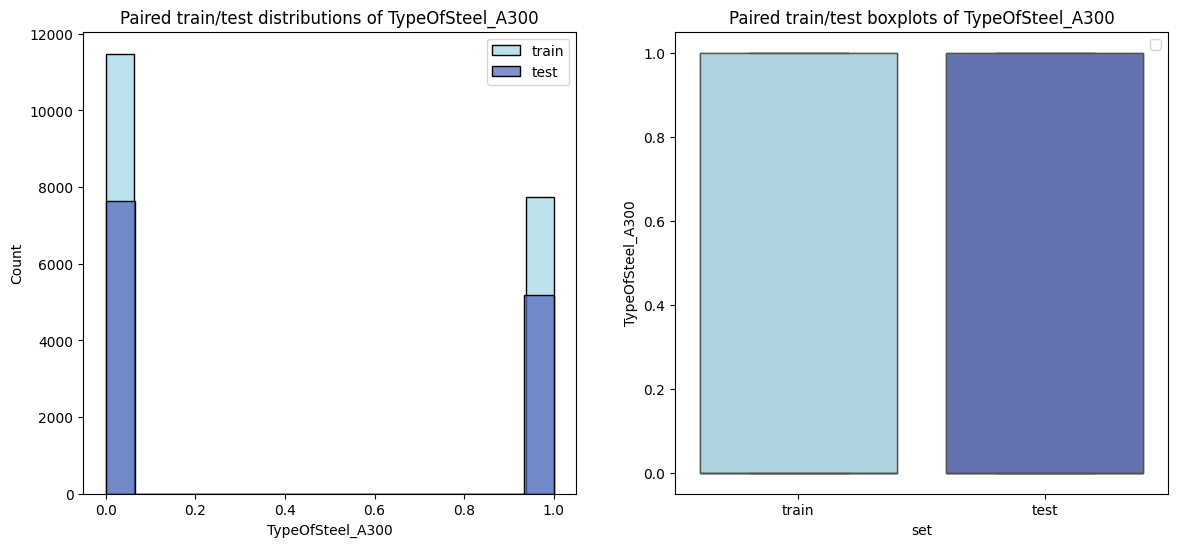

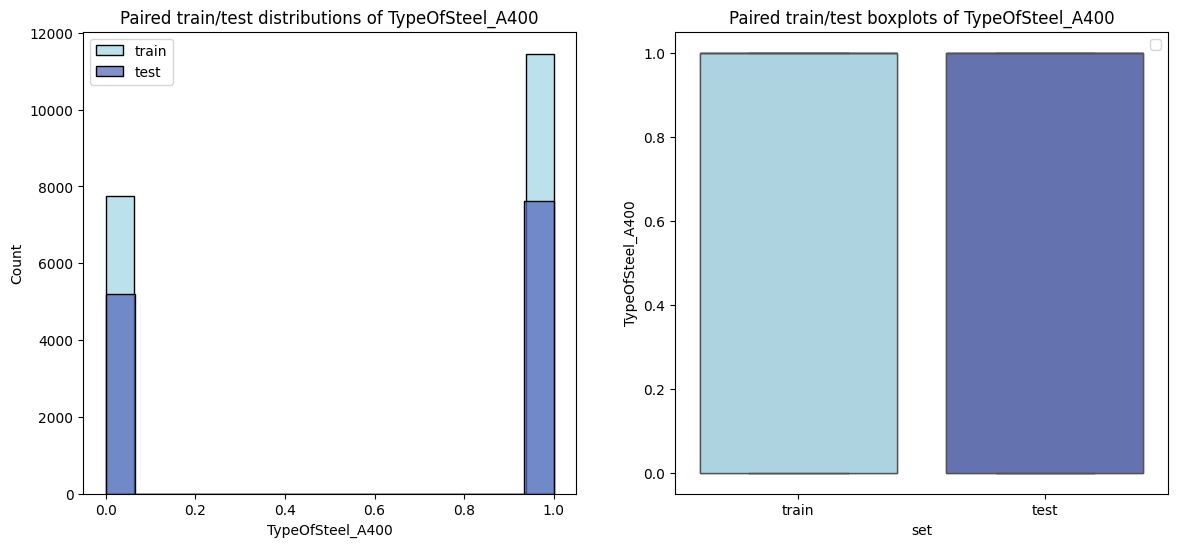

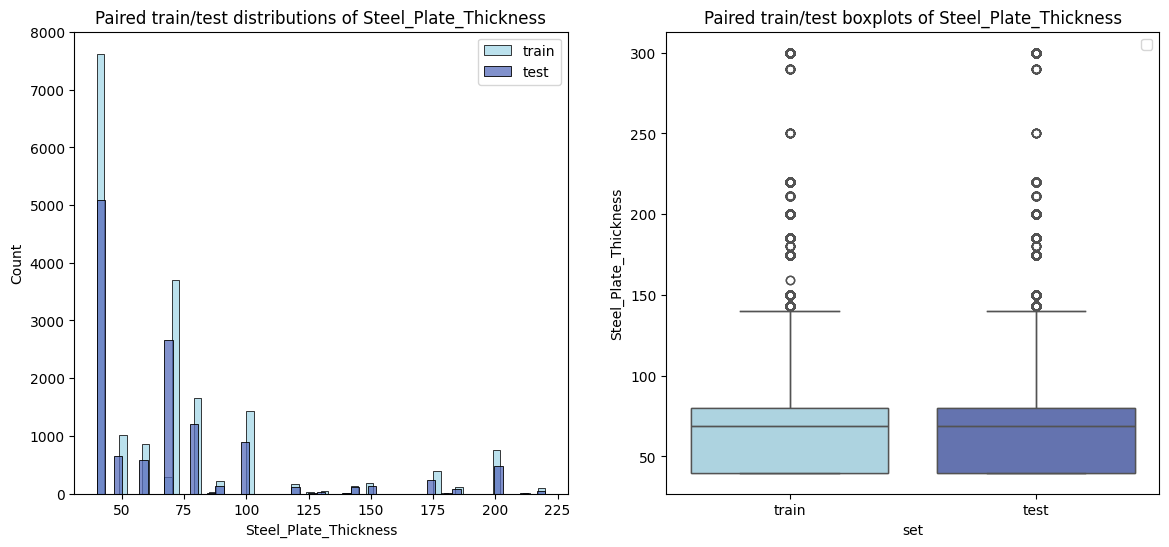

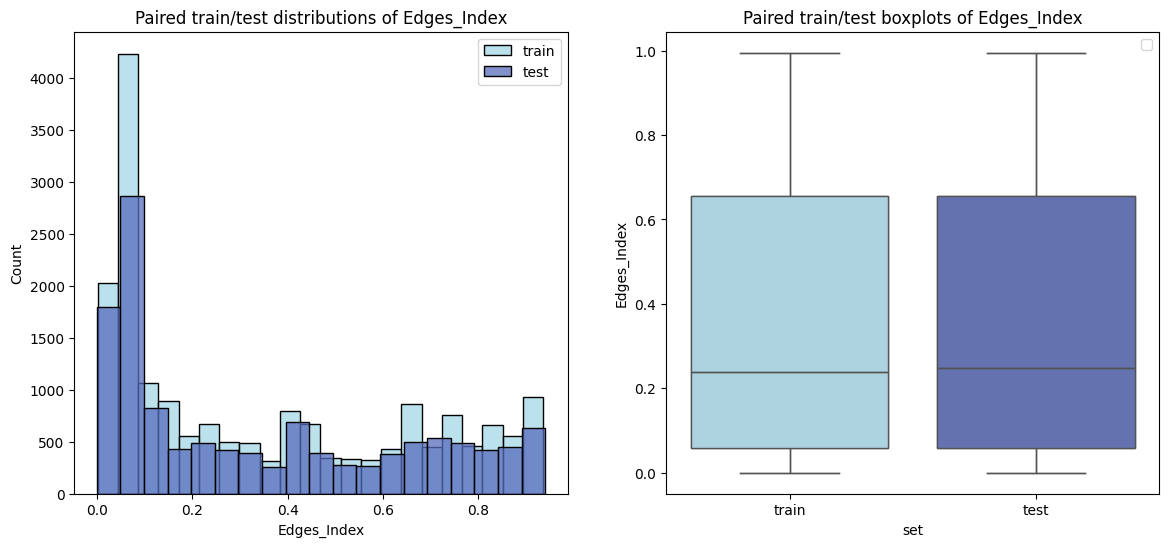

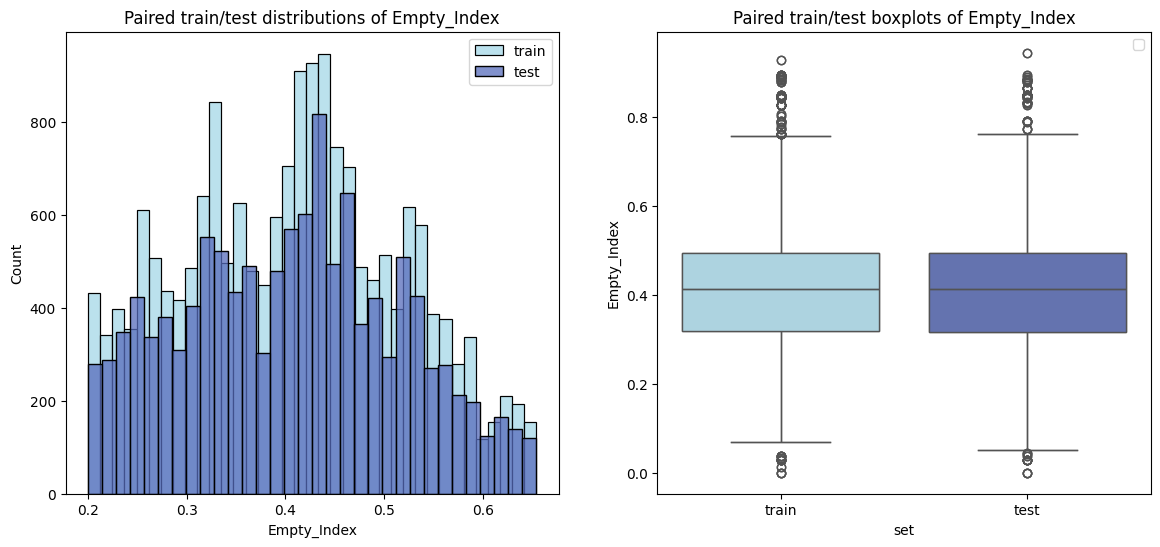

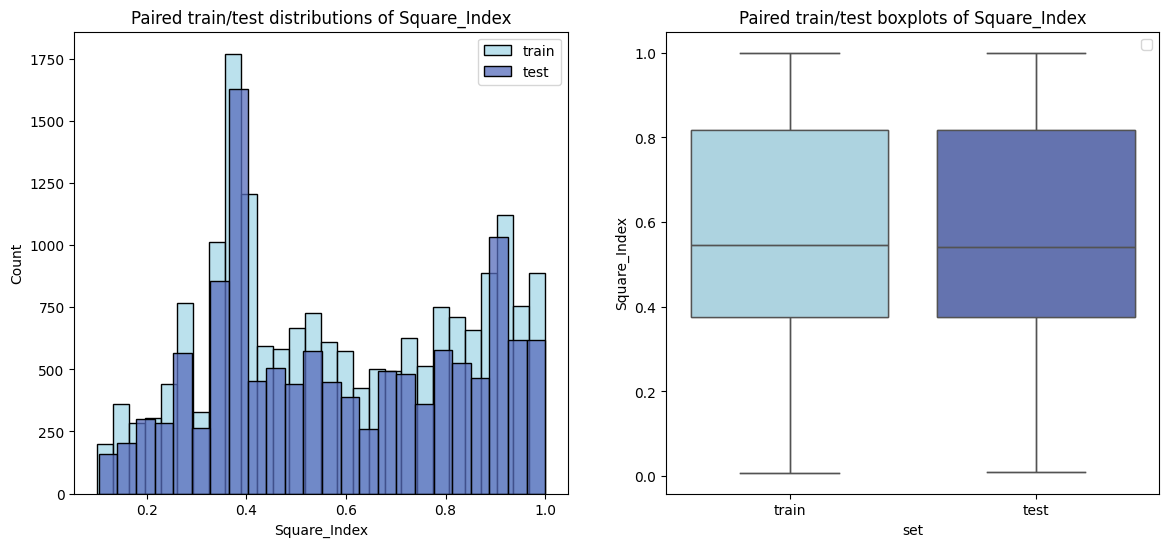

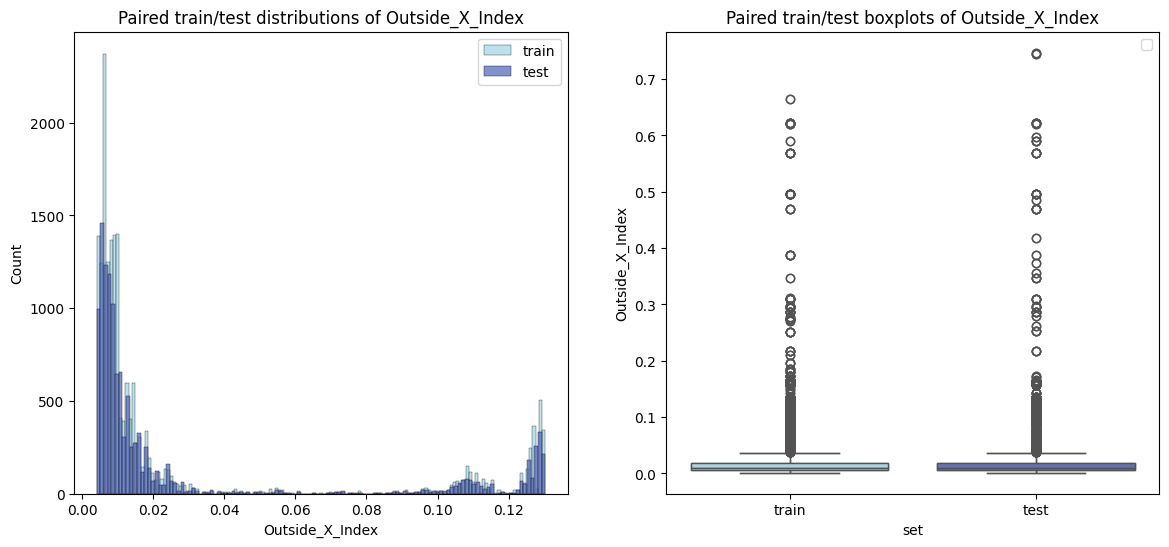

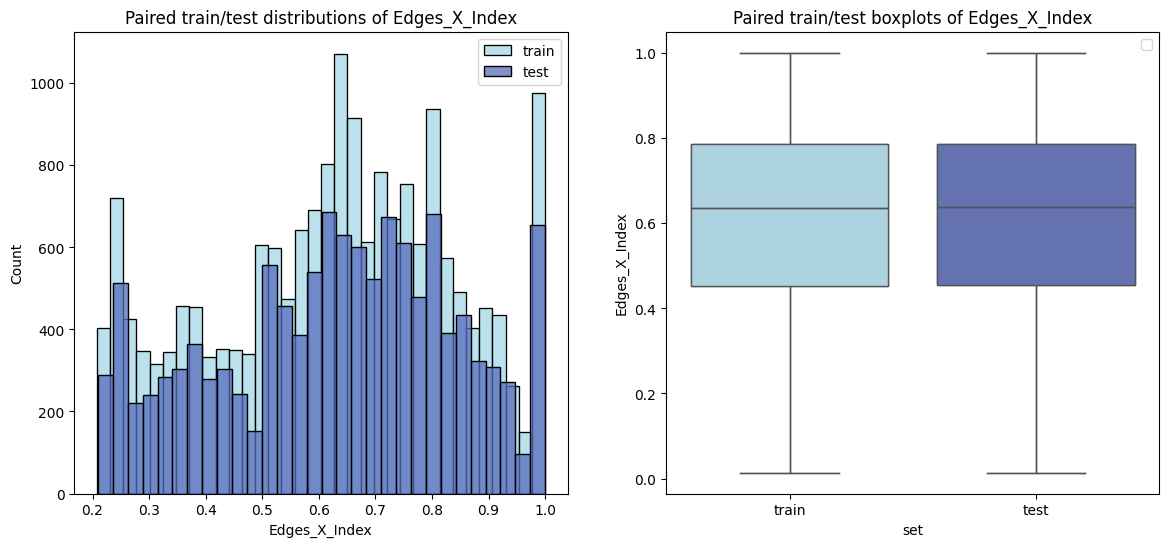

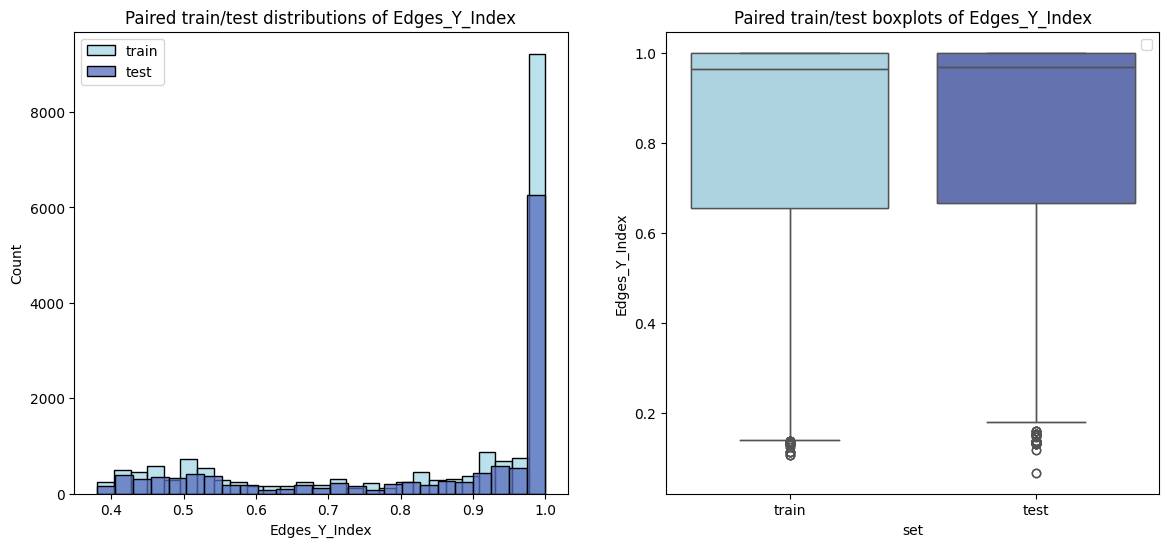

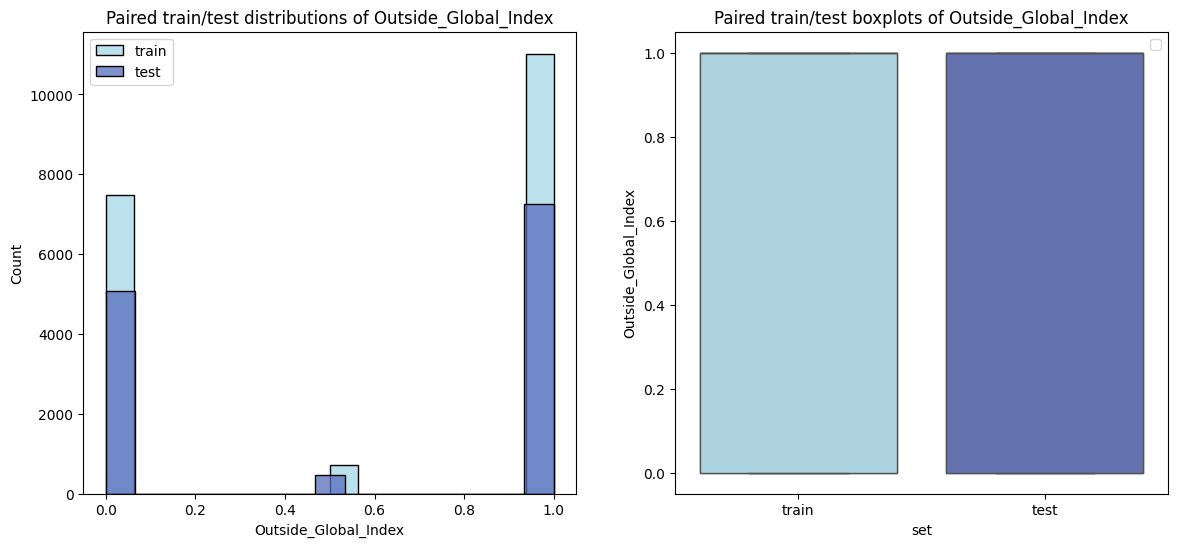

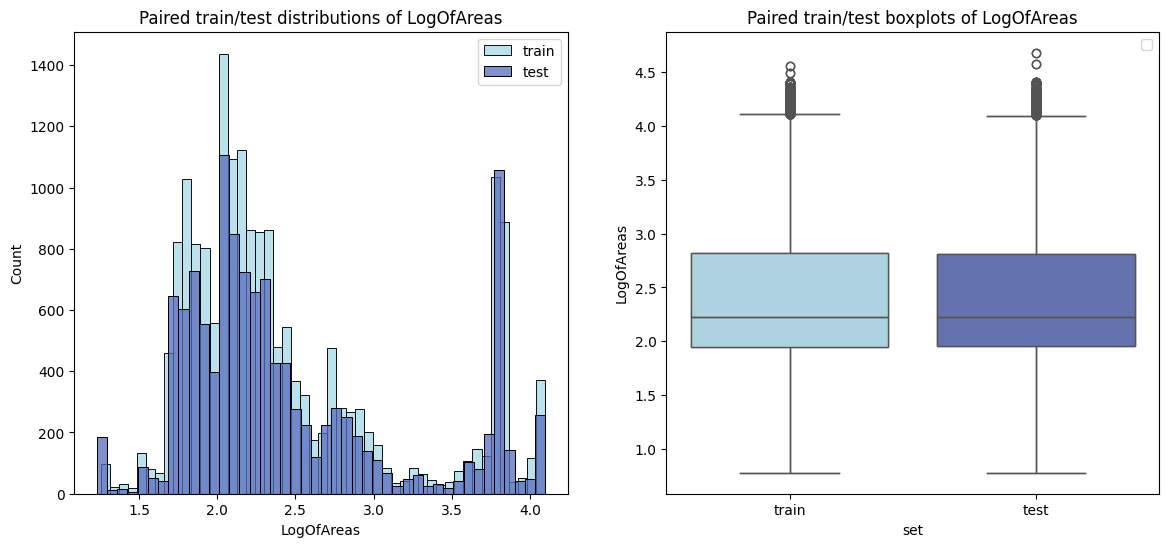

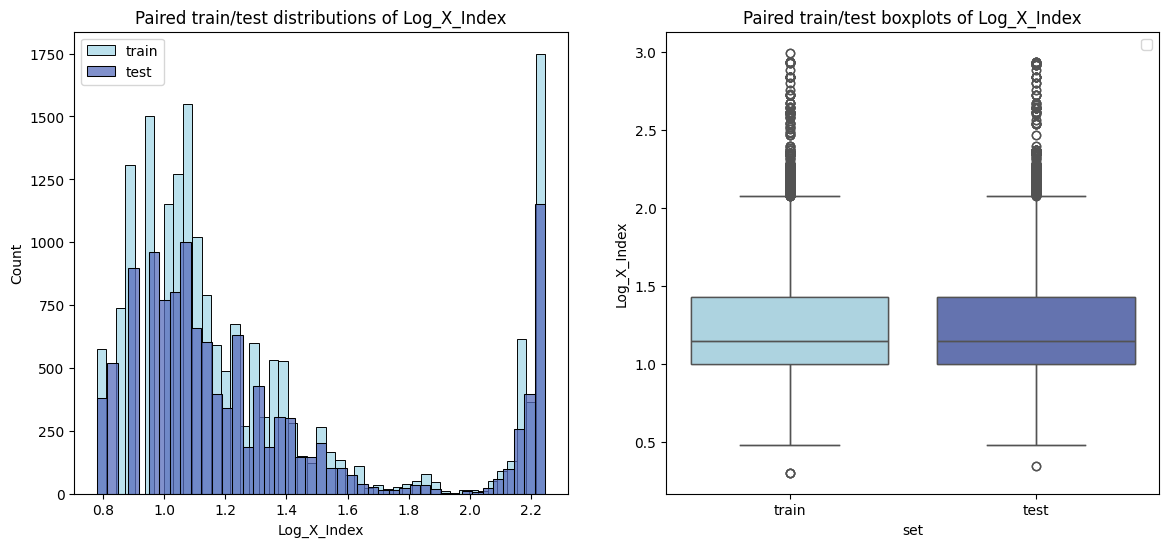

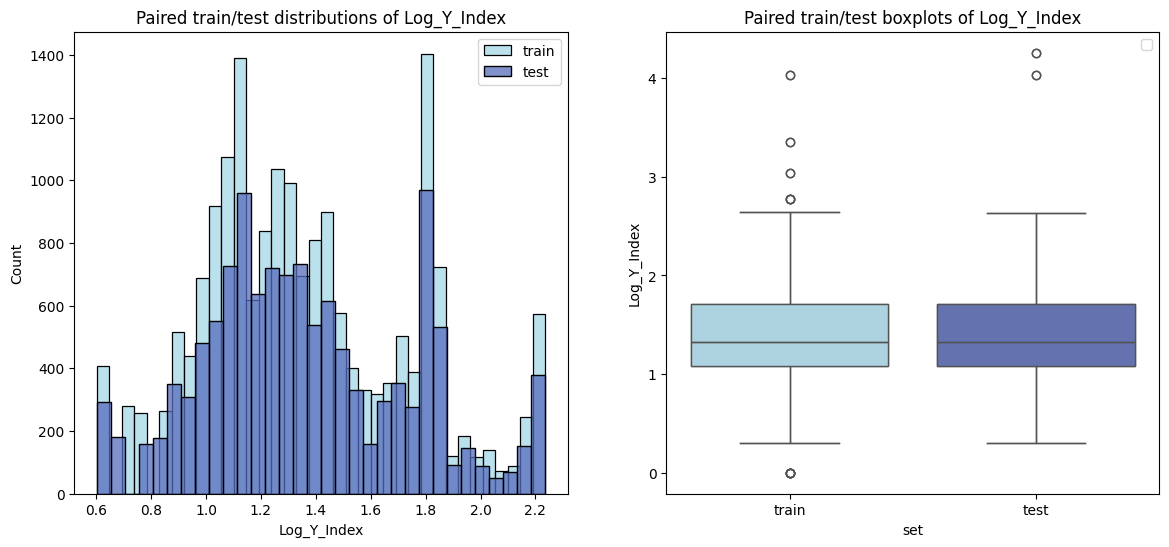

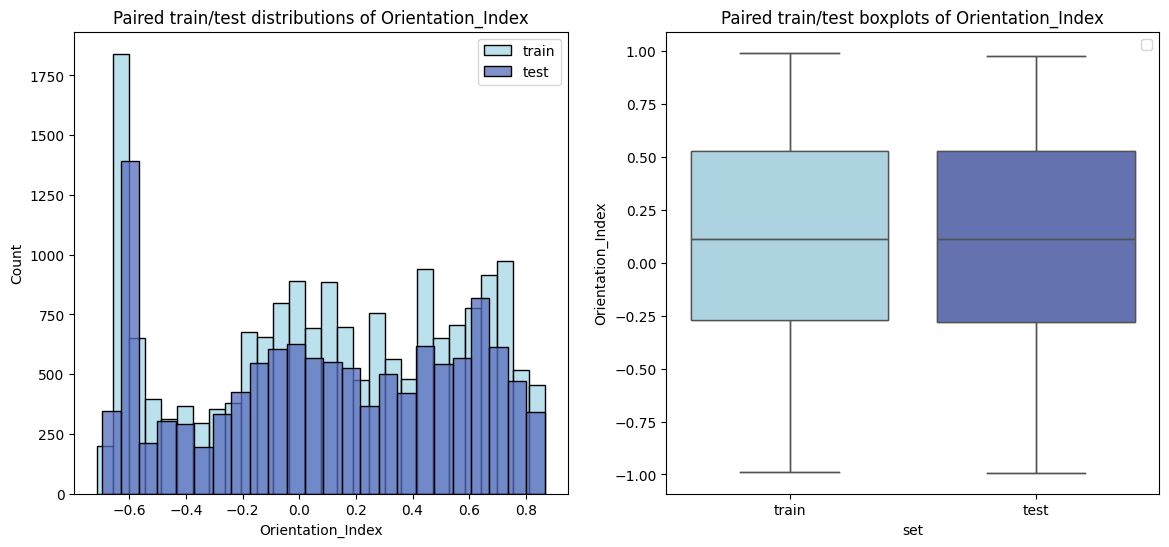

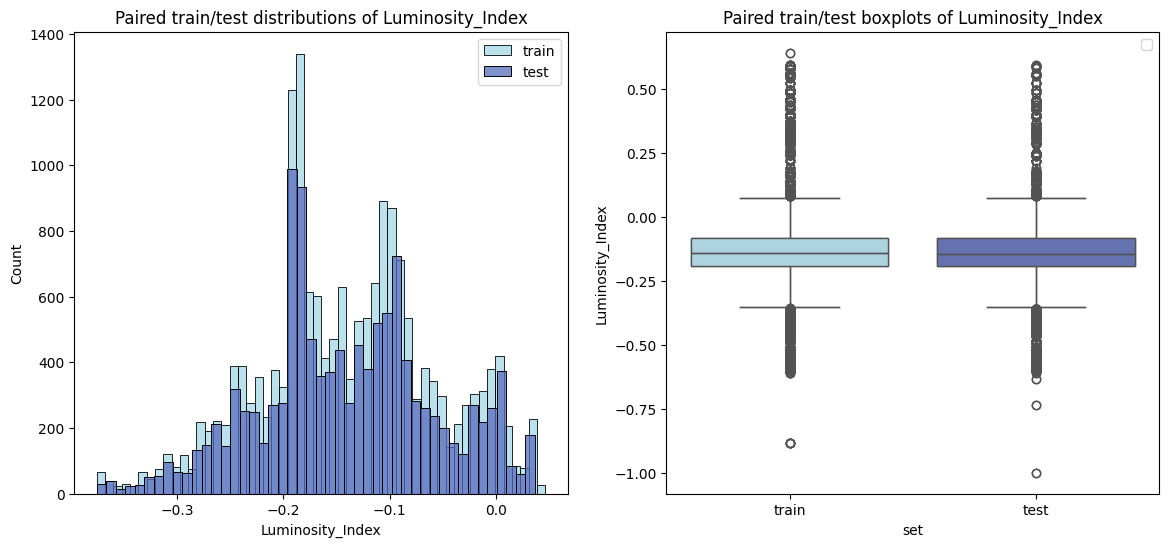

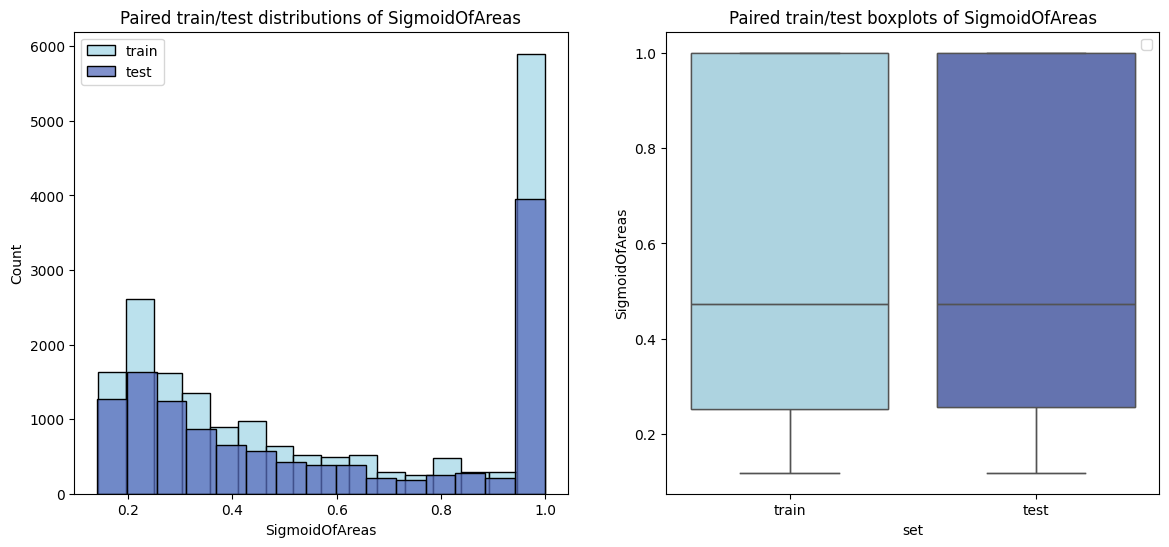

In [ ]:
def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    data_df = train.copy()  # 학습 데이터셋을 카피해서
    data_df['set'] = 'train'  # set이라는 컬럼에 train이라는 값으로 채움
    data_df = pd.concat([data_df, test.copy()]).fillna('test')  # 카피한 데이터를 concat 후 결측값(테스트 데이터셋)은 test로 채움
    data_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # 양의 무한대와 음의 무한대는 결측값으로 대체

    f, axes = plt.subplots(1, 2, figsize=(14, 6))
    for i, s in enumerate(data_df[hue].unique()):  # hue 컬럼의 유니크값을 순회하면서
        selection = data_df.loc[data_df[hue] == s, feature]
        q_025, q_975 = np.percentile(selection, [2.5, 97.5])
        selection_filtered = selection[(selection >= q_025) & (selection <= q_975)]
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=FutureWarning)
            sns.histplot(selection_filtered, color=palette[i], ax=axes[0], label=s)
            sns.boxplot(x=hue, y=feature, data=data_df, palette=palette, ax=axes[1])
    axes[0].set_title(f"Paired train/test distributions of {feature}")
    axes[1].set_title(f"Paired train/test boxplots of {feature}")
    axes[0].legend()
    axes[1].legend()
    plt.show()

for feature in train.columns:
    plot_distribution_pairs(train, test, feature, palette=color_list)

### 적대적 교차 검증
일반적으로 training set과 test set 간의 분포 차이를 보기 위해서 사용한다. 

분포의 차이?
- 분포는 일반적으로 데이터의 값이 특정 범위에서 어떻게 퍼져있는지를 나타내는 척도이다.
- 훈련 데이터와 테스트 데이터의 특성 값들의 분포가 유사하면, 모델은 훈련한 내용을 테스트 데이터에 잘 적용할 가능성이 높아진다.

해당 검증의 경우 ROC-AUC score를 사용한다.

### AUC
Area of Under the Curve를 의미하는 AUC는, 머신러닝의 분류 모델 성능을 평가하는 핵심 요소 중 하나이다. 곡선 아래의 면적이 넓을 수록 좋은 성능임을 의미한다.

### ROC
Receiver Operating Characteristic을 의미하는 ROC는, 분류 모델의 True Positive Rate(TPR)과 False Positive Rate(FPR)의 관계를 그래프로 나타낸다. 

이는 다양한 threshold에 대한 분류기의 성능을 한 번에 표현한 것이다.

### roc_auc_score
해당 스코어의 경우 1에 가까울수록 완벽한 분류를 의미하고, 0.5에 가까울 수록 랜덤 예측(유의미한 패턴을 학습하지 못한 상태), 0.5보다 낮으면 랜덤 예측보다도 나쁜 성능(예측 결과가 반대)을 의미한다.

이를 적대적 교차 검증에 적용하면,
- roc_auc_score $ \approx $ 0.5 = train set, test set의 분포가 비슷함.
- roc_auc_score > 0.5 = train set, test set이 다른 분포를 가질 가능성이 높아짐.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

X = pd.concat([train, test], axis=0)
y = [0]*len(train) + [1]*len(test)

model = RandomForestClassifier(random_state=0)
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1, method='predict_proba')

score = roc_auc_score(y_true=y, y_score=cv_preds[:, 1])
print(f"roc-auc score : {score:0.3f}")

roc-auc score : 0.496


### Feature Engineering - Range

좌표 별 범위 : 좌표 범위를 계산하여 각 단층의 공간적 범위에 대한 정보를 캡쳐한다. 공간적 범위가 큰 단층은 강판에 더 심각한 결함이나 이상이 있을 수 있기에, 이는 관련이 있을 수 있다.

In [24]:
def calculate_coordinate_range_features(data):
    data['X_Range'] = (data['X_Maximum'] - data['X_Minimum'])
    data['Y_Range'] = (data['Y_Maximum'] - data['Y_Minimum'])

    return data

train = calculate_coordinate_range_features(train)
test = calculate_coordinate_range_features(test)

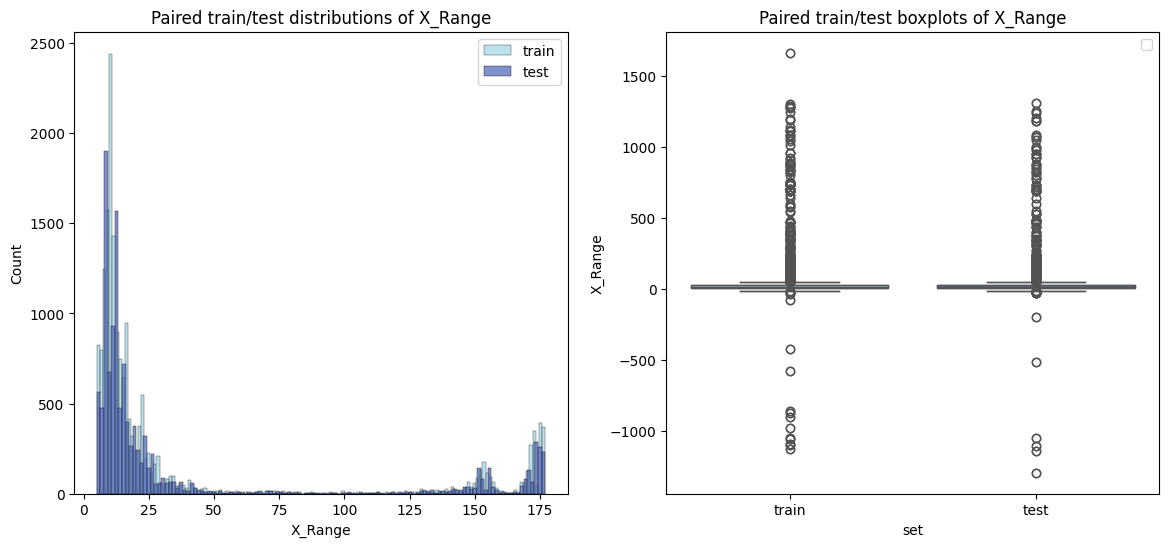

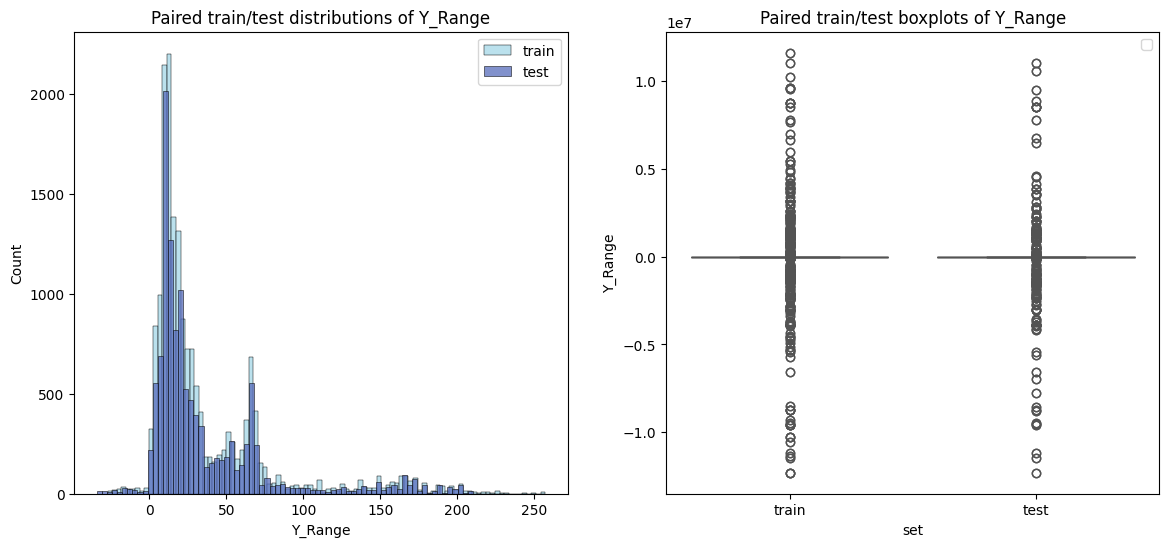

In [26]:
plot_distribution_pairs(train, test, feature="X_Range", palette=color_list)
plot_distribution_pairs(train, test, feature="Y_Range", palette=color_list)

### Feature Engineering - Area Perimeter

크기 비율 특징 : 둘레에 대한 면적 비율은 각 단층의 조밀함 또는 불규칙성에 대한 인사이트를 찾을 수 있다. 면적 대 주변 비율이 높은 단층은 형상이 더 불규칙할 수 있으며, 이는 잠재적으로 복잡한 결함으로 인해 면밀한 검사가 필요하다는 것을 나타낼 수 있다.

In [27]:
def calculate_size_ratio_features(data):
    data['Area_Perimeter_Ratio'] = data['Pixels_Areas'] / (data['X_Perimeter'] + data['Y_Perimeter'])
    return data

train = calculate_size_ratio_features(train)
test = calculate_size_ratio_features(test)

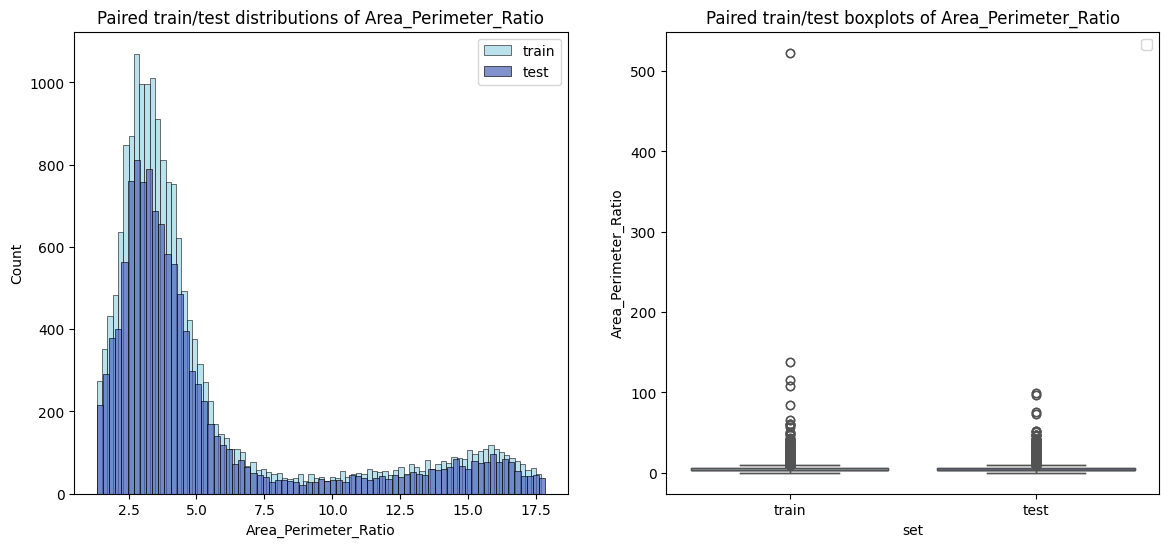

In [29]:
plot_distribution_pairs(train, test, feature='Area_Perimeter_Ratio', palette=color_list)

### Feature Engineering - Luminosity

광도 범위 특징 : 결함 영역 내의 광도 값 범위는 밝기 또는 어둠의 변화를 나타낼 수 있으며, 이는 다양한 유형 또는 결함의 심각성과 관련이 있을 수 있다. 예를 들어, 광도 범위가 클수록 밝기 수준이 대조적인 영역을 나타낼 수 있으며, 이는 심각한 결함이 있는 영역을 강조할 수 있다.

In [30]:
def calculate_luminosity_range_feature(data):
    data['Luminosity_Range'] = (data['Maximum_of_Luminosity'] - data['Minimum_of_Luminosity'])
    return data

train = calculate_luminosity_range_feature(train)
test = calculate_luminosity_range_feature(test)

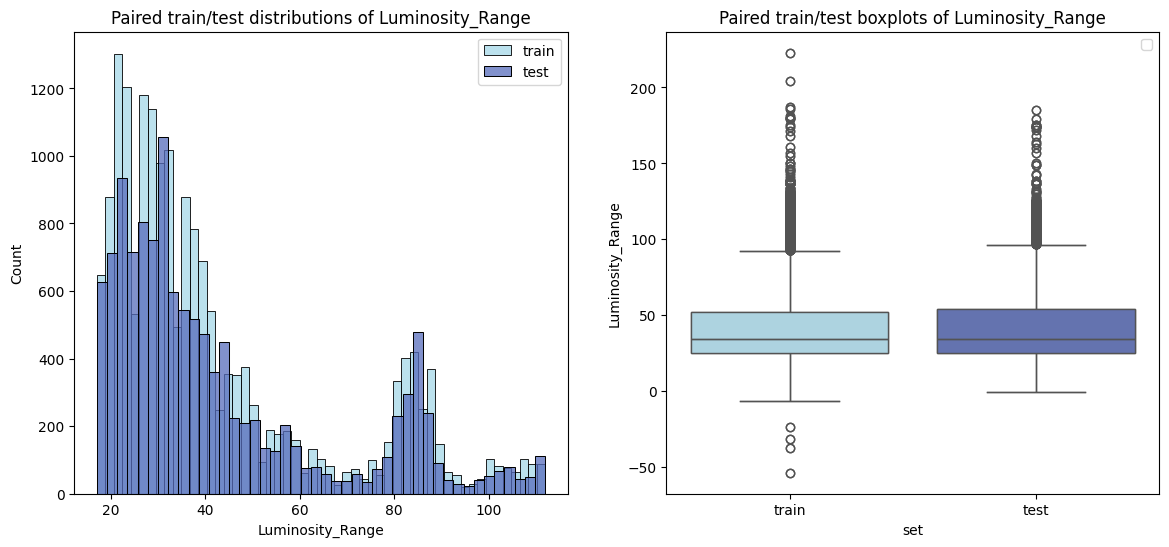

In [31]:
plot_distribution_pairs(train, test, feature="Luminosity_Range", palette=color_list)

In [32]:
train.to_csv("../data/treated_train.csv") 
test.to_csv("../data/treated_test.csv") 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 정규화
train = train.astype(np.float64)
test = test.astype(np.float64)

scaler = MinMaxScaler()
scaler.fit(train)

train[:] = scaler.transform(train)
test[:] = scaler.transform(test)

In [34]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(train, y=target)

In [35]:
list(cv_splits)

[(array([    0,     2,     3, ..., 19216, 19217, 19218]),
  array([    1,     9,    23, ..., 19196, 19201, 19213])),
 (array([    0,     1,     2, ..., 19215, 19216, 19218]),
  array([    7,     8,    20, ..., 19194, 19195, 19217])),
 (array([    0,     1,     2, ..., 19216, 19217, 19218]),
  array([    3,    10,    11, ..., 19205, 19211, 19215])),
 (array([    0,     1,     2, ..., 19214, 19215, 19217]),
  array([    5,     6,    18, ..., 19209, 19216, 19218])),
 (array([    1,     3,     5, ..., 19216, 19217, 19218]),
  array([    0,     2,     4, ..., 19210, 19212, 19214]))]

### Modeling

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_auc_score
from xgboost import XGBClassifier

# 모델 학습 
cv_splits = cv.split(train, y=target)
roc_auc_scores = []
cv_oof = pd.DataFrame(np.zeros((len(target), len(target_classes))), columns=target_classes)

for train_idx, val_idx in cv_splits:
    xgb = XGBClassifier(
        booster="gbtree",
        tree_method='hist',
        objective="multi:softmax",
        num_class=len(set(target)),
        n_estimators=300,
        max_depth=6,
        verbosity=0
        )
    X_train_fold, X_val_fold = train.iloc[train_idx], train.iloc[val_idx]
    y_train_fold, y_val_fold = target[train_idx], target[val_idx]

    xgb.fit(X_train_fold, y_train_fold)

    y_val_prob = xgb.predict_proba(X_val_fold)
    roc_auc = roc_auc_score(target_bin.iloc[val_idx], y_val_prob[:, 1:], multi_class='ovr')

    cv_oof.iloc[val_idx, :] = y_val_prob

    roc_auc_scores.append(roc_auc)

roc_auc_mean = np.mean(roc_auc_scores)
roc_auc_std = np.std(roc_auc_scores)
roc_auc_max = np.max(roc_auc_scores)
roc_auc_min = np.min(roc_auc_scores)

print(f"Cross-validated Roc-AUC score : {roc_auc_mean:.3f} +/- {roc_auc_std:.3f}")
print(f"Max Roc-AUC score : {roc_auc_max:.3f}")
print(f"Min Roc-AUC score : {roc_auc_min:.3f}")

print("Cross-validation defect dataset")
print("MaxMinScaler")

Cross-validated Roc-AUC score : 0.872 +/- 0.004
Max Roc-AUC score : 0.876
Min Roc-AUC score : 0.864


In [39]:
from sklearn.metrics import classification_report

print(classification_report(target, np.argmax(cv_oof, axis=1), target_names=target_classes))

              precision    recall  f1-score   support

Zero_Defects       0.15      0.01      0.02       818
      Pastry       0.37      0.20      0.26      1465
   Z_Scratch       0.60      0.58      0.59      1150
    K_Scatch       0.87      0.90      0.89      3432
      Stains       0.71      0.79      0.75       568
   Dirtiness       0.40      0.15      0.22       485
       Bumps       0.48      0.49      0.48      4761
Other_Faults       0.46      0.57      0.51      6540

    accuracy                           0.55     19219
   macro avg       0.50      0.46      0.46     19219
weighted avg       0.53      0.55      0.54     19219



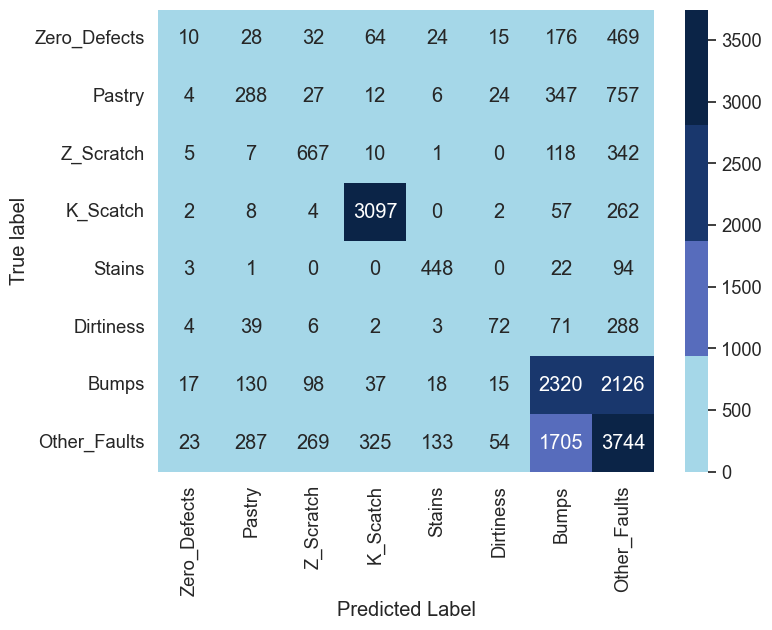

In [40]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=target, y_pred=np.argmax(cv_oof, axis=1))
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap_custom, xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True label')
plt.show()

In [ ]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    params = {
        'grow_poilcy':trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'n_estimators':trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate':trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'gamma':trial.suggest_float('gamma', 1e-9, 0.5),
        'subsample':trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth':trial.suggest_int('max_depth', 0, 12),
        'min_child_weight':trial.suggest_int('min_child_weight', 1, 7),
        'reg_lambda':trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha':trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
    }

    params['booster'] = 'gbtree'
    params['objective'] = 'multi:softmax'
    params['verbosity'] = 0
    params['tree_method'] = 'hist'

    cv_splits = cv.split(train, y=target)
    cv_scores = []

    for train_idx, val_idx in cv_splits:
        xgb = XGBClassifier(**params)
        X_train_fold, X_val_fold = train.iloc[train_idx], train.iloc[val_idx]
        y_train_fold, y_val_fold = target[train_idx], target(val_idx)

        xgb.fit(X_train_fold, y_train_fold)
        y_val_prob = xgb.predict_proba(X_val_fold)
        cv_scores.append(roc_auc_score(target_bin.iloc[val_idx], y_val_prob[:, 1:], multi_class='ovr'))

    cv_evaluation = np.mean(cv_scores)
    return cv_evaluation

In [43]:
run_optimization = False
if run_optimization:
    sqlite_db = "sqlite:///sqlite.db"
    study_name = "multi_class_prediction_of_obesity_risk"
    study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                                sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0),
                                direction="maximize", load_if_exists=True)

    study.optimize(objective, n_trials=100)
    best_cls_params = study.best_params
    best_value = study.best_value

else:
    
    best_value = 0.88887
    best_cls_params = {'grow_policy': 'depthwise', 
                       'n_estimators': 785, 
                       'learning_rate': 0.020726270353596147, 
                       'gamma': 0.13894214878891328, 
                       'subsample': 0.6931112900708679, 
                       'colsample_bytree': 0.5210477365658035, 
                       'max_depth': 3, 
                       'min_child_weight': 2, 
                       'reg_lambda': 5.369876648869387e-06, 
                       'reg_alpha': 8.428323563897863e-09}

print(f"best optmized accuracy: {best_value:0.5f}")
print(f"best hyperparameters: {best_cls_params}")

best_cls_params['objective'] = 'multi:softmax'
best_cls_params['tree_method'] = "hist"
best_cls_params["verbosity"] = 0

best optmized accuracy: 0.88887
best hyperparameters: {'grow_policy': 'depthwise', 'n_estimators': 785, 'learning_rate': 0.020726270353596147, 'gamma': 0.13894214878891328, 'subsample': 0.6931112900708679, 'colsample_bytree': 0.5210477365658035, 'max_depth': 3, 'min_child_weight': 2, 'reg_lambda': 5.369876648869387e-06, 'reg_alpha': 8.428323563897863e-09}


In [44]:
xgb = xgb = XGBClassifier(**best_cls_params)
xgb.fit(train, target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5210477365658035, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.13894214878891328,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=0.020726270353596147,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=785, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [45]:
from xgboost import DMatrix

booster = xgb.get_booster()

feature_names = train.columns
Xd = DMatrix(train)

shap_values = booster.predict(Xd, pred_contribs=True)
preds = booster.predict(Xd)

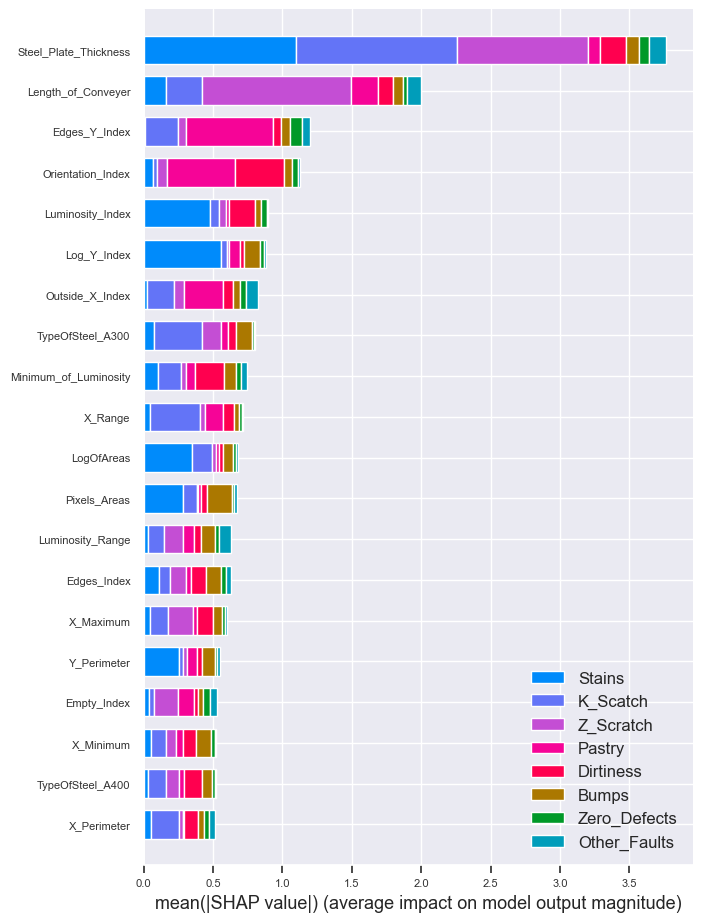

In [47]:
import shap
import matplotlib.pyplot as plt

shap.summary_plot(
    [shap_values[:, k, :-1] for k in range(shap_values.shape[1])],
    train.values,
    plot_type="bar",
    feature_names = feature_names,
    class_names=target_classes,
    show=False
)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()
print()

VIOLIN PLOT REPRESENTING <Zero_Defects>


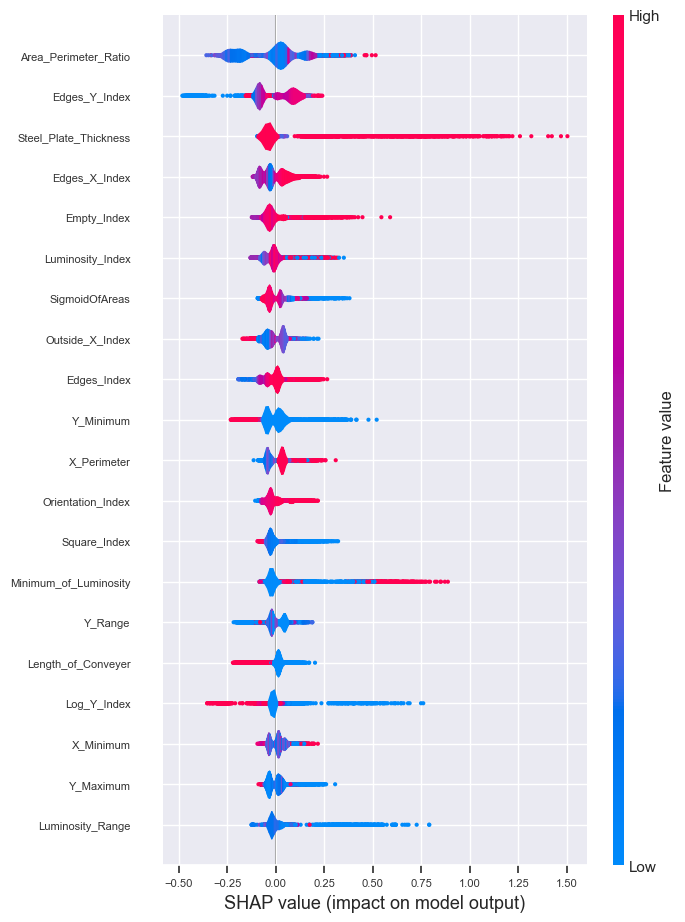


VIOLIN PLOT REPRESENTING <Pastry>


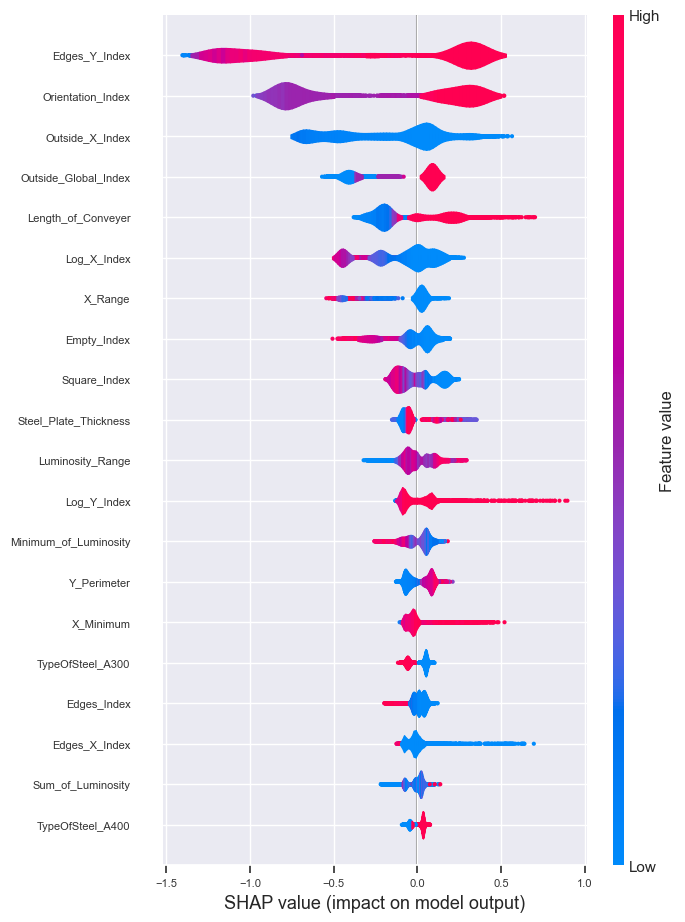


VIOLIN PLOT REPRESENTING <Z_Scratch>


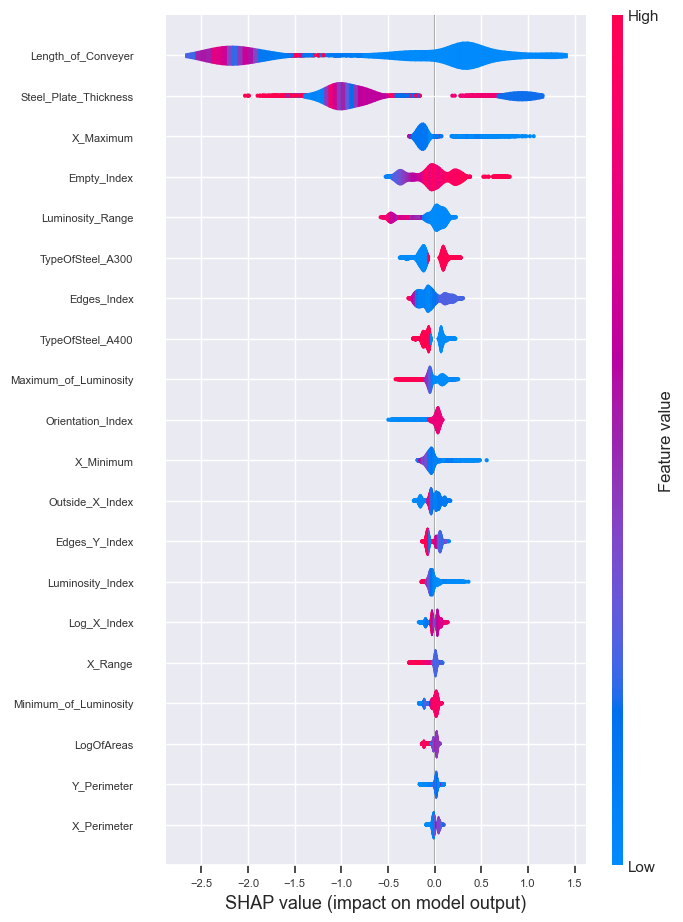


VIOLIN PLOT REPRESENTING <K_Scatch>


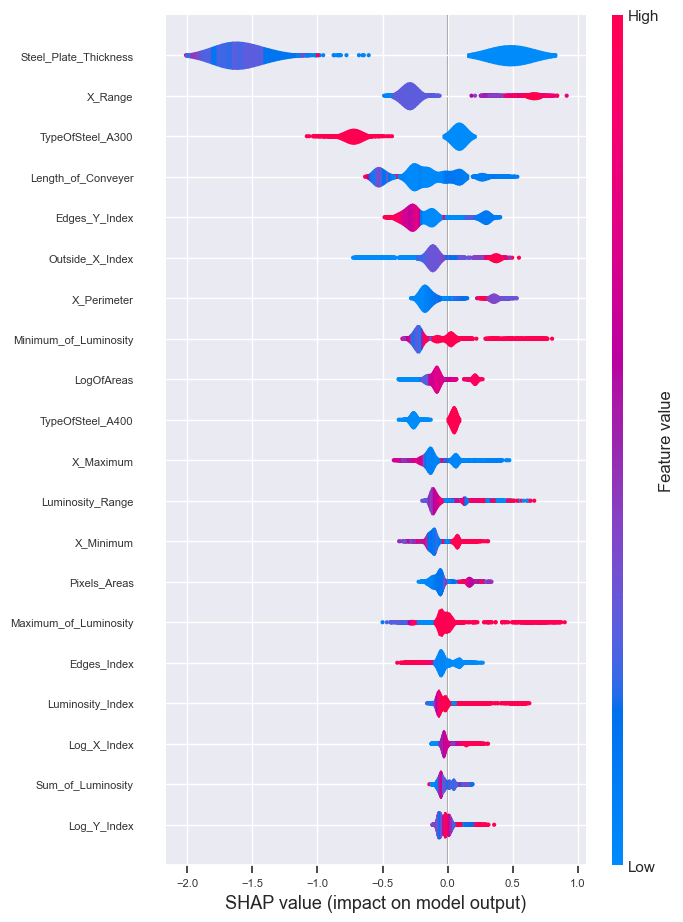


VIOLIN PLOT REPRESENTING <Stains>


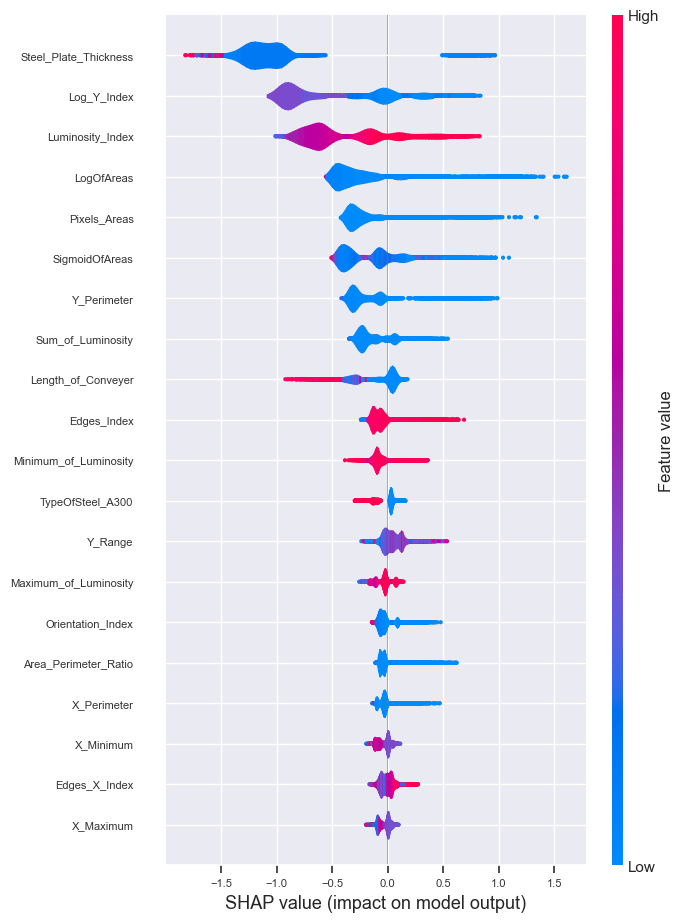


VIOLIN PLOT REPRESENTING <Dirtiness>


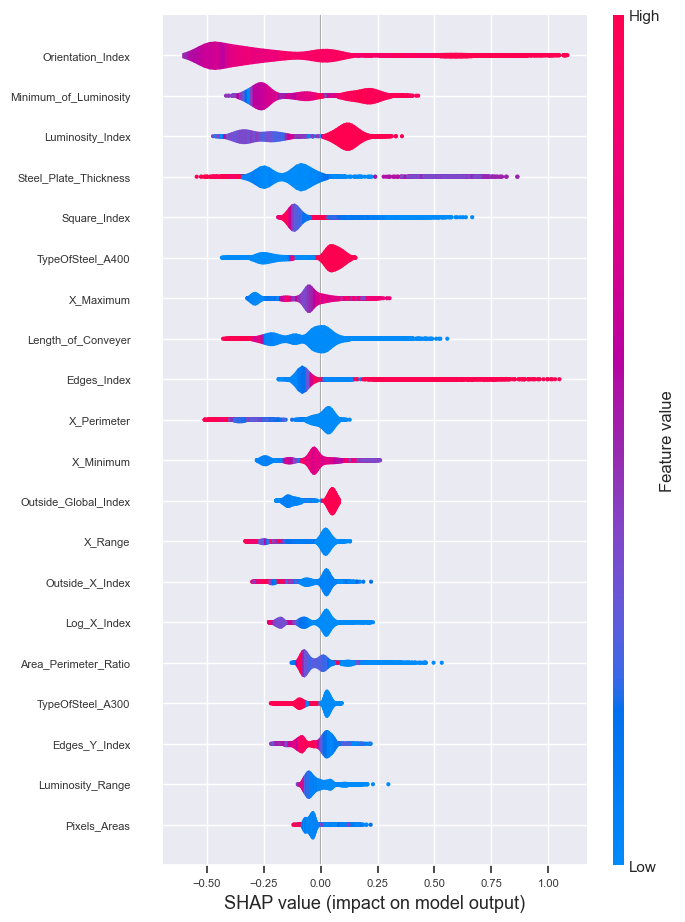


VIOLIN PLOT REPRESENTING <Bumps>


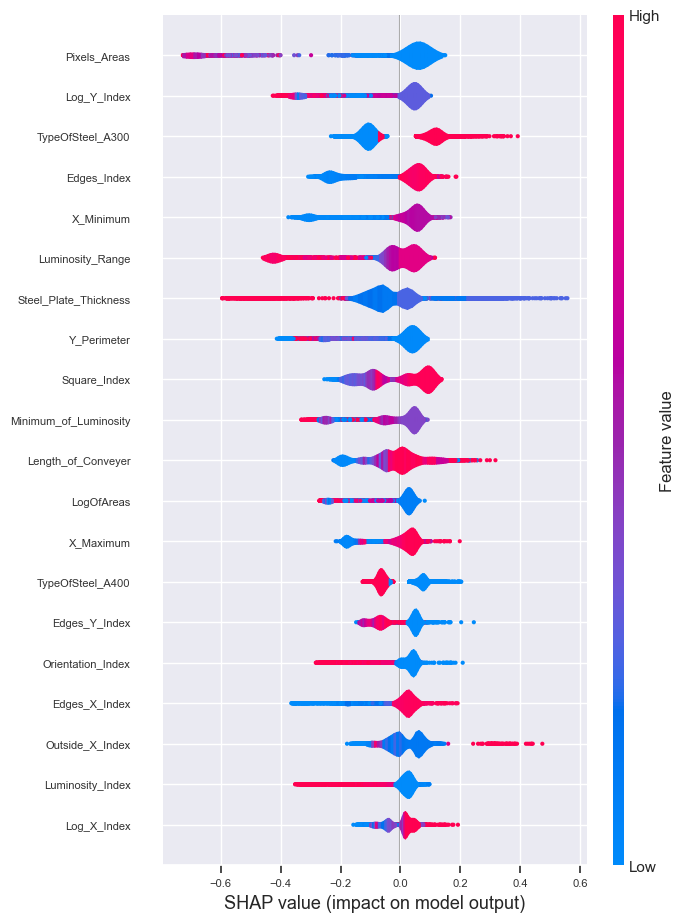


VIOLIN PLOT REPRESENTING <Other_Faults>


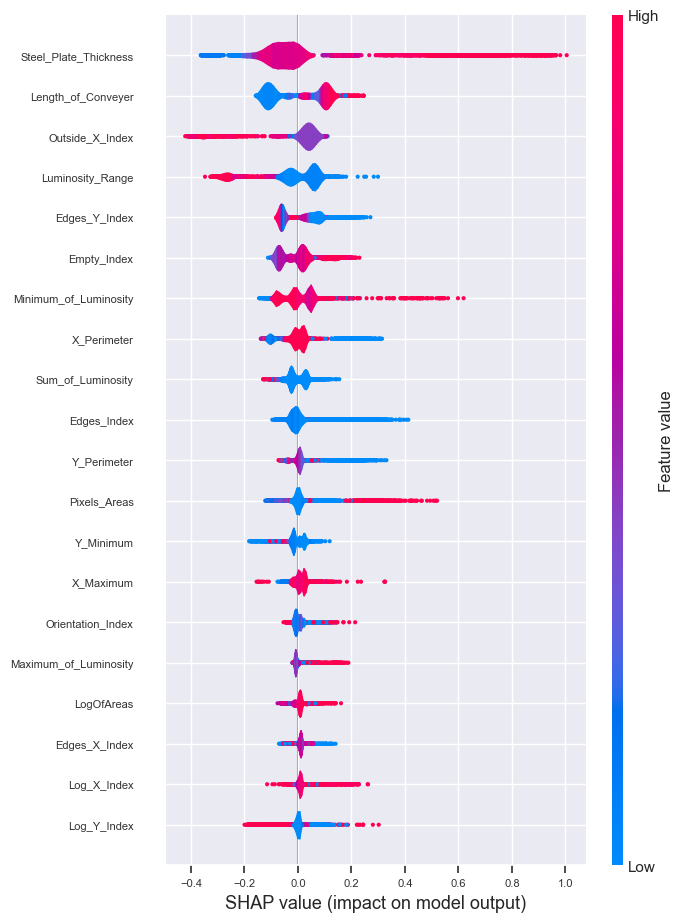

In [48]:
for k, target_label in enumerate(target_classes):
    print(f"VIOLIN PLOT REPRESENTING <{target_label}>")
    shap.summary_plot(shap_values[:, k, :-1], train.values, plot_type='violin', feature_names=feature_names, show=False)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()
    print()